In [3]:
import sys
print(sys.executable)

C:\Users\salma\.conda\envs\cogsci-lab\python.exe


In [4]:
import torch

In [5]:
import mlflow

In [6]:
from model import MemoryRNN
from data_loader import generate_task_data
from train import train_model
print("Successfully imported all modules.")

Successfully imported all modules.


In [7]:
# --- 2. CONFIGURATION: Defining the Experiment Parameters ---

INPUT_SIZE = 3      # Vocabulary size (Pad, A, B)
HIDDEN_SIZE = 16    # The model's memory capacity
OUTPUT_SIZE = 3     # Number of possible answers the model can give
SEQUENCE_LENGTH = 10# How long the model needs to remember the signal
#250  600  900 1300
NUM_EPOCHS = 300   # How many training cycles to run
BATCH_SIZE = 120    # How many examples to show the model at once
LEARNING_RATE = 0.005 # How quickly the model learns

In [21]:
# --- Branch 1: MLflow Setup _ Last cell---
mlflow.set_experiment("LSTM_Memory_Task_Final_")

# This command starts a "new page" in our lab notebook for this specific run.
# Everything indented below will be recorded.
with mlflow.start_run():
    
    # --- Log the parameters (the "Methods" section of our report) ---
    print("Logging parameters to MLflow...")
    mlflow.log_param("model_type", "LSTM")
    mlflow.log_param("hidden_size", HIDDEN_SIZE)
    mlflow.log_param("num_epochs", NUM_EPOCHS)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    
    
    # --- 3. INSTANTIATION: Building the Model ---
    print("\nCreating the MemoryRNN (LSTM) model...")
    model = MemoryRNN(
        input_size=INPUT_SIZE, 
        hidden_size=HIDDEN_SIZE, 
        output_size=OUTPUT_SIZE
    )
    
    
    # --- 4. EXECUTION: The Training Process ---
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("--- Starting Training ---")
    for epoch in range(NUM_EPOCHS):
        inputs, labels = generate_task_data(BATCH_SIZE, SEQUENCE_LENGTH)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')
            # --- NEW: Log the metric (the "Results" section) ---
            # We log the loss at each step to see a learning curve.
            mlflow.log_metric("training_loss", loss.item(), step=epoch+1)
            
    print("--- Training Complete ---")
    
    
    # --- 5. EXAMINATION & Final Logging ---
    print("\n--- Testing the Trained Model ---")
    model.eval()
    
    correct_predictions = 0
    total_tests = 100 # Let's test on 100 new examples for a better accuracy measure
    
    with torch.no_grad():
        test_inputs, test_labels = generate_task_data(total_tests, SEQUENCE_LENGTH)
        test_outputs = model(test_inputs)
        _, predicted_indices = torch.max(test_outputs.data, 1)
        
        correct_predictions += (predicted_indices == test_labels).sum().item()
        
    accuracy = correct_predictions / total_tests
    print(f"Final Accuracy on {total_tests} test samples: {accuracy:.2%}")
    
    # --- NEW: Log the final accuracy metric ---
    mlflow.log_metric("final_accuracy", accuracy)

    # --- NEW: Log the model itself (the "Artifact") ---
    # This saves the trained model as a file associated with this run.
    print("Logging model artifact to MLflow...")
    mlflow.pytorch.log_model(model, "trained_model")
    
print("\nExperiment run finished and logged to MLflow.")
# --- END------

Logging parameters to MLflow...

Creating the MemoryRNN (LSTM) model...
--- Starting Training ---
Epoch [25/300], Loss: 0.7578
Epoch [50/300], Loss: 0.7187
Epoch [75/300], Loss: 0.4920
Epoch [100/300], Loss: 0.0525
Epoch [125/300], Loss: 0.0159
Epoch [150/300], Loss: 0.0093
Epoch [175/300], Loss: 0.0066
Epoch [200/300], Loss: 0.0050
Epoch [225/300], Loss: 0.0041
Epoch [250/300], Loss: 0.0033
Epoch [275/300], Loss: 0.0028
Epoch [300/300], Loss: 0.0024


2025/09/01 10:05:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


--- Training Complete ---

--- Testing the Trained Model ---
Final Accuracy on 100 test samples: 100.00%
Logging model artifact to MLflow...


2025/09/01 10:05:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Experiment run finished and logged to MLflow.


In [9]:
# --- Branch 2 :Normal Setup  ---
# --- 3. INSTANTIATION ---

print("\nCreating the MemoryRNN model...")
rnn_model = MemoryRNN(
    input_size=INPUT_SIZE, 
    hidden_size=HIDDEN_SIZE, 
    output_size=OUTPUT_SIZE
)
print(rnn_model)


Creating the MemoryRNN model...
MemoryRNN(
  (lstm): LSTM(3, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)


In [10]:
# --- Normal Setup _ Last Cell ---
# --- 4. EXECUTION: Running the Training Process ---

trained_model = train_model(
    model=rnn_model,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    learning_rate=LEARNING_RATE
)

# --- 5. EXAMINATION: Testing the Trained Model ---

print("\n--- Testing the Trained Model on a New, Unseen Example ---")

# Set the model to evaluation mode. 
#This is a good practice that turns off certain training-specific layers like Dropout.
trained_model.eval()

# The `torch.no_grad()` context manager tells PyTorch that we are not
# training, so it doesn't need to calculate gradients, which saves memory and computation.
with torch.no_grad():
    # Generate one single, new test sample the model has never seen before.
    test_input, test_label = generate_task_data(1, SEQUENCE_LENGTH)
    
    # Get the model's raw output (logits) for this test sample.
    test_output = trained_model(test_input)
    
    # Find the model's actual prediction by finding the index of the highest logit.
    _, predicted_idx = torch.max(test_output.data, 1)

    signal_map = {1: 'A', 2: 'B'}
    correct_signal = signal_map[test_label.item()]
    predicted_signal = signal_map[predicted_idx.item()]
    
    print(f"The task was to remember the signal: '{correct_signal}'")
    print(f"The model's final prediction was:     '{predicted_signal}'")
    
    if correct_signal == predicted_signal:
        print("\n[SUCCESS]: The model has learned to integrate information over time.")
    else:
        print("\n[FAILURE]: The model did not learn the task. Consider increasing NUM_EPOCHS.")
# --- END------

--- Starting Training ---
Epoch [25/300], Loss: 0.7449
Epoch [50/300], Loss: 0.7022
Epoch [75/300], Loss: 0.6909
Epoch [100/300], Loss: 0.6944
Epoch [125/300], Loss: 0.7005
Epoch [150/300], Loss: 0.7006
Epoch [175/300], Loss: 0.6999
Epoch [200/300], Loss: 0.6646
Epoch [225/300], Loss: 0.0711
Epoch [250/300], Loss: 0.0113
Epoch [275/300], Loss: 0.0068
Epoch [300/300], Loss: 0.0051
--- Training Complete ---

--- Testing the Trained Model on a New, Unseen Example ---
The task was to remember the signal: 'B'
The model's final prediction was:     'B'

[SUCCESS]: The model has learned to integrate information over time.


In [8]:
# --- 6. ANALYSIS: The "Φ-Scope" Experiment ---

import numpy as np
import matplotlib.pyplot as plt
from analysis import calculate_predictive_information

Generating a large dataset for analysis...
Running the model to capture hidden states...

--- Starting Predictive Information Analysis (max τ = 10) ---
τ = 1: Average Mutual Information = 1.1747
τ = 2: Average Mutual Information = 0.9837
τ = 3: Average Mutual Information = 0.8963
τ = 4: Average Mutual Information = 0.8904
τ = 5: Average Mutual Information = 0.9595
τ = 6: Average Mutual Information = 0.9799
τ = 7: Average Mutual Information = 1.0430
τ = 8: Average Mutual Information = 1.0414
τ = 9: Average Mutual Information = 0.6929
--- Analysis Complete ---


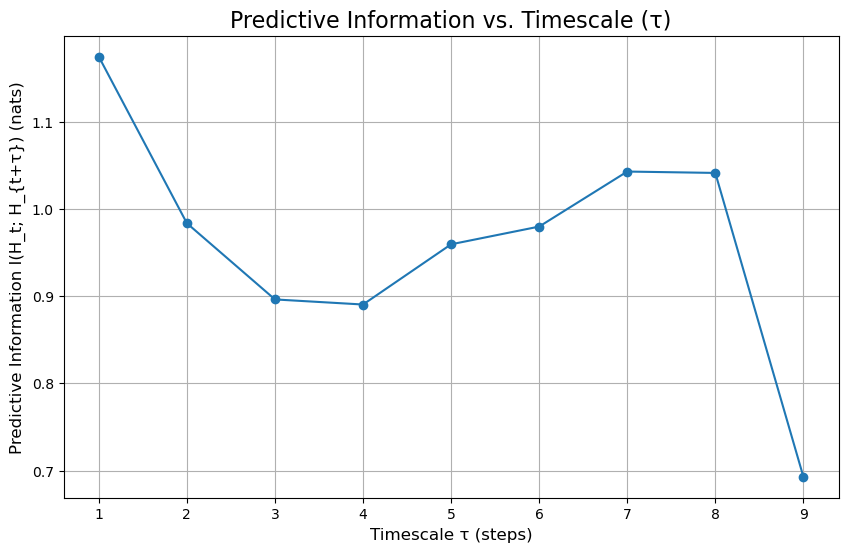

In [11]:

# We need to generate a large batch of data to run through the trained model
# to get a stable estimate of its hidden state dynamics.
print("Generating a large dataset for analysis...")
analysis_inputs, _ = generate_task_data(num_samples=1000, sequence_length=SEQUENCE_LENGTH)

# We need a special "hook" to capture the hidden states during a forward pass
hidden_states_log = []
def hook_function(module, input, output):
    # The LSTM's output is a tuple (all_step_outputs, (final_h_n, final_c_n))
    # We want the output of the LSTM layer for all time steps
    hidden_states_log.append(output[0].detach())

# Attach the hook to lstm layer of trained model
hook = trained_model.lstm.register_forward_hook(hook_function)

# Run the model on the analysis data to trigger the hook and log the states
print("Running the model to capture hidden states...")
trained_model.eval()
with torch.no_grad():
    trained_model(analysis_inputs)

hook.remove()

# concatenate and convert logged states
captured_hidden_states = torch.cat(hidden_states_log).numpy()


#setting max_tau to be one less than the sequence length
pi_results = calculate_predictive_information(captured_hidden_states, max_tau=SEQUENCE_LENGTH)

# --- 7. VISUALIZATION: Plotting the Results ---

# Extract the tau values and their corresponding MI scores
taus = list(pi_results.keys())
mi_values = list(pi_results.values())

plt.figure(figsize=(10, 6))
plt.plot(taus, mi_values, marker='o', linestyle='-')
plt.title('Predictive Information vs. Timescale (τ)', fontsize=16)
plt.xlabel('Timescale τ (steps)', fontsize=12)
plt.ylabel('Predictive Information I(H_t; H_{t+τ}) (nats)', fontsize=12)
plt.grid(True)
plt.xticks(taus)
plt.show()